In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision 
import torchvision.transforms as transforms
from torchvision.io import read_image

from torchinfo import summary
from PIL import Image

from tqdm.auto import tqdm
import wandb

np.random.seed(42)
torch.random.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [2]:
wandb.login(key='0810c26db151787365c181033f8346ab6bb06137')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\VICTUS\_netrc
wandb: Currently logged in as: vugiakhai2004 (vugiakhai2004-n) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
img_path = '../data/raw/images/Images'

In [9]:
len(os.listdir(img_path)) # Number unique classes

120

In [5]:
img_path_test = os.path.join(img_path, 'n02085620-Chihuahua', 'n02085620_242.jpg')
img = read_image(img_path_test)

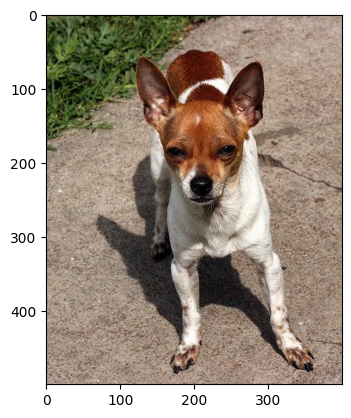

In [6]:
plt.imshow(img.cpu().permute(1, 2, 0))

In [7]:
# Number class
len(os.listdir(img_path))

120

In [10]:
# create mapping
classes = sorted(os.listdir(img_path))

label2idx = {label: idx for idx, label in enumerate(classes)}

idx2label = {idx: label for label, idx in label2idx.items()}

In [11]:
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dim = len(os.listdir(img_path))
epochs = 100
lr = 0.001
train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [12]:
class Custom_dataset(Dataset):
    def __init__(self, img_path, label2idx, transforms=None, split='train'):
        self.img_path = img_path
        self.label2idx = label2idx
        self.transforms = transforms
        self.split = split

        self.img_paths, self.labels, self.classes = self.read_image_path()

        train_paths, val_paths, train_labels, val_labels = train_test_split(
            self.img_paths,
            self.labels,
            test_size=0.2,
            random_state=42,
            shuffle=True,
            stratify=self.labels
        )

        train_paths, test_paths, train_labels, test_labels = train_test_split(
            train_paths,
            train_labels,
            test_size=0.125,
            random_state=42,
            shuffle=True,
            stratify=train_labels
        )

        if self.split == 'train':
            self.img_paths = train_paths
            self.labels = train_labels
        elif self.split == 'val':
            self.img_paths = val_paths
            self.labels = val_labels
        elif self.split == 'test':
            self.img_paths = test_paths
            self.labels = test_labels

    def read_image_path(self):
        img_paths = []
        labels = []
        classes = []

        for class_name in sorted(os.listdir(self.img_path)):

            classes.append(class_name)
            class_path = os.path.join(self.img_path, class_name)

            for img_name in sorted(os.listdir(class_path)):

                img_path = os.path.join(class_path, img_name)
                img_paths.append(img_path)
                labels.append(self.label2idx[class_name])

        return img_paths, labels, classes

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        # img = Image.open(img_path).convert('RGB')
        img = read_image(img_path).float() / 255.0

        if img.shape[0] == 4:
            img = img[:3, :, :]

        if self.transforms:
            img = self.transforms(img)


        label = self.labels[idx]

        return img, label

In [13]:
transforms_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])
    
transforms_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

In [14]:
train_data = Custom_dataset(img_path, label2idx, transforms=transforms_train, split='train')
val_data = Custom_dataset(img_path, label2idx, transforms=transforms_val, split='val')
test_data = Custom_dataset(img_path, label2idx, transforms=transforms_val, split='test')

In [15]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size*2, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size*2, shuffle=False)

In [16]:
class Resnet50(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50, self).__init__()
        self.model = torchvision.models.resnet50(weights='DEFAULT')
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        for name, param in self.model.named_parameters():
            if name.startswith('fc'):
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        num_features = self.model.fc.in_features
        # self.model.fc = nn.Sequential(
        #     nn.Dropout(0.5),
        #     nn.Linear(num_features, 512),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(512),
        #     nn.Dropout(0.5),
        #     nn.Linear(512, num_classes)
        # )

        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, X):
        return self.model(X)

    def unfreeze(self):
        for name, param in self.model.named_parameters():
            param.requires_grad = True


In [20]:
model = Resnet50(num_classes=output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
    
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

In [15]:
summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
Resnet50                                      [32, 120]                 --
├─ResNet: 1-1                                 [32, 120]                 --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         (70,400)
│    │    └─Bottleneck: 3-3                   [32, 256, 56, 56]         (70,400)
│    └─Sequential: 2-6                        [32, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [32, 512, 28, 28]      

In [17]:
break_count = 0
max_count = 10
best_model_path = '../models/resnet50_finetune.pth'
best_val_loss = float('inf')

In [17]:
# Khởi tạo wandb
wandb.init(
    project="fintune_model",  # Tên project
    name="Resnet50_finetune",  # Tên run
    config={
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": lr,
        "optimizer": "Adam",
        "model": "Resnet50_finetune",
        "num_classes": output_dim
    }
)

# Có thể truy cập config sau này qua wandb.config
config = wandb.config

In [18]:
def compute_accuracy(output, y):
    predict_label = torch.argmax(output, dim=1)
    return (predict_label == y).float().mean()

In [ ]:
for epoch in tqdm(range(epochs), desc='Current epoch/Total epochs', position=0):

    train_epoch_loss = 0
    train_epoch_acc = 0
    val_epoch_loss = 0
    val_epoch_acc = 0

    model.train()
    for X, y in tqdm(train_loader, desc='Training batch', position=1, leave=False):

        X = X.to(device)
        y = y.to(device)

        output = model(X)
        loss = criterion(output, y)
        train_epoch_loss += loss.item()
        acc = compute_accuracy(output, y)
        train_epoch_acc += acc.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss.append(train_epoch_loss / len(train_loader))
    train_acc.append(train_epoch_acc / len(train_loader))

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc='Validation batch', position=1, leave=False):

            X = X.to(device)
            y = y.to(device)

            output = model(X)
            loss = criterion(output, y)
            val_epoch_loss += loss.item()
            acc = compute_accuracy(output, y)
            val_epoch_acc += acc.item()
    
    val_loss.append(val_epoch_loss / len(val_loader))
    val_acc.append(val_epoch_acc / len(val_loader))

    scheduler.step(val_loss[-1])

    current_lr = optimizer.param_groups[0]['lr']
    
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss[-1],
        "train_acc": train_acc[-1],
        "val_loss": val_loss[-1],
        "val_acc": val_acc[-1],
        "learning_rate": current_lr
    })

    if val_loss[-1] < best_val_loss:
        break_count = 0
        best_val_loss = val_loss[-1]
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': val_loss[-1],
            'best_accuracy': val_acc[-1],
            'label2idx': label2idx,
            'idx2label': idx2label
        }, best_model_path)
    else:
        break_count += 1
    
    if break_count >= max_count: 
        print(f'Break at epoch {epoch} with best val loss: {best_val_loss}')
        break

    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss[-1]}, Train Acc: {train_acc[-1]}, Val Loss: {val_loss[-1]}, Val Acc: {val_acc[-1]}')

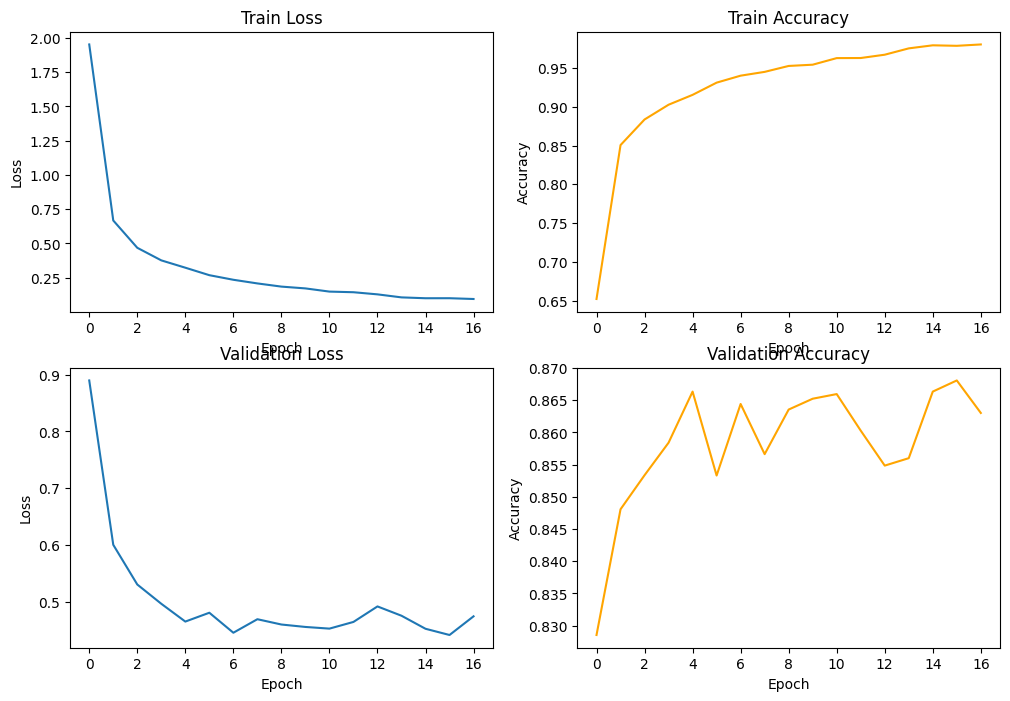

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(train_loss)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Train Loss')

ax[0, 1].plot(train_acc, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[0, 1].set_title('Train Accuracy')

ax[1, 0].plot(val_loss)
ax[1, 0].set(xlabel='Epoch', ylabel='Loss')
ax[1, 0].set_title('Validation Loss')

ax[1, 1].plot(val_acc, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Use model load if not train

In [21]:
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [22]:
model.eval()
with torch.no_grad():
    test_acc = 0
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        output = model(X)
        acc = compute_accuracy(output, y)
        test_acc += acc.item()
    
    print(test_acc / len(test_loader))

0.8670454549066948


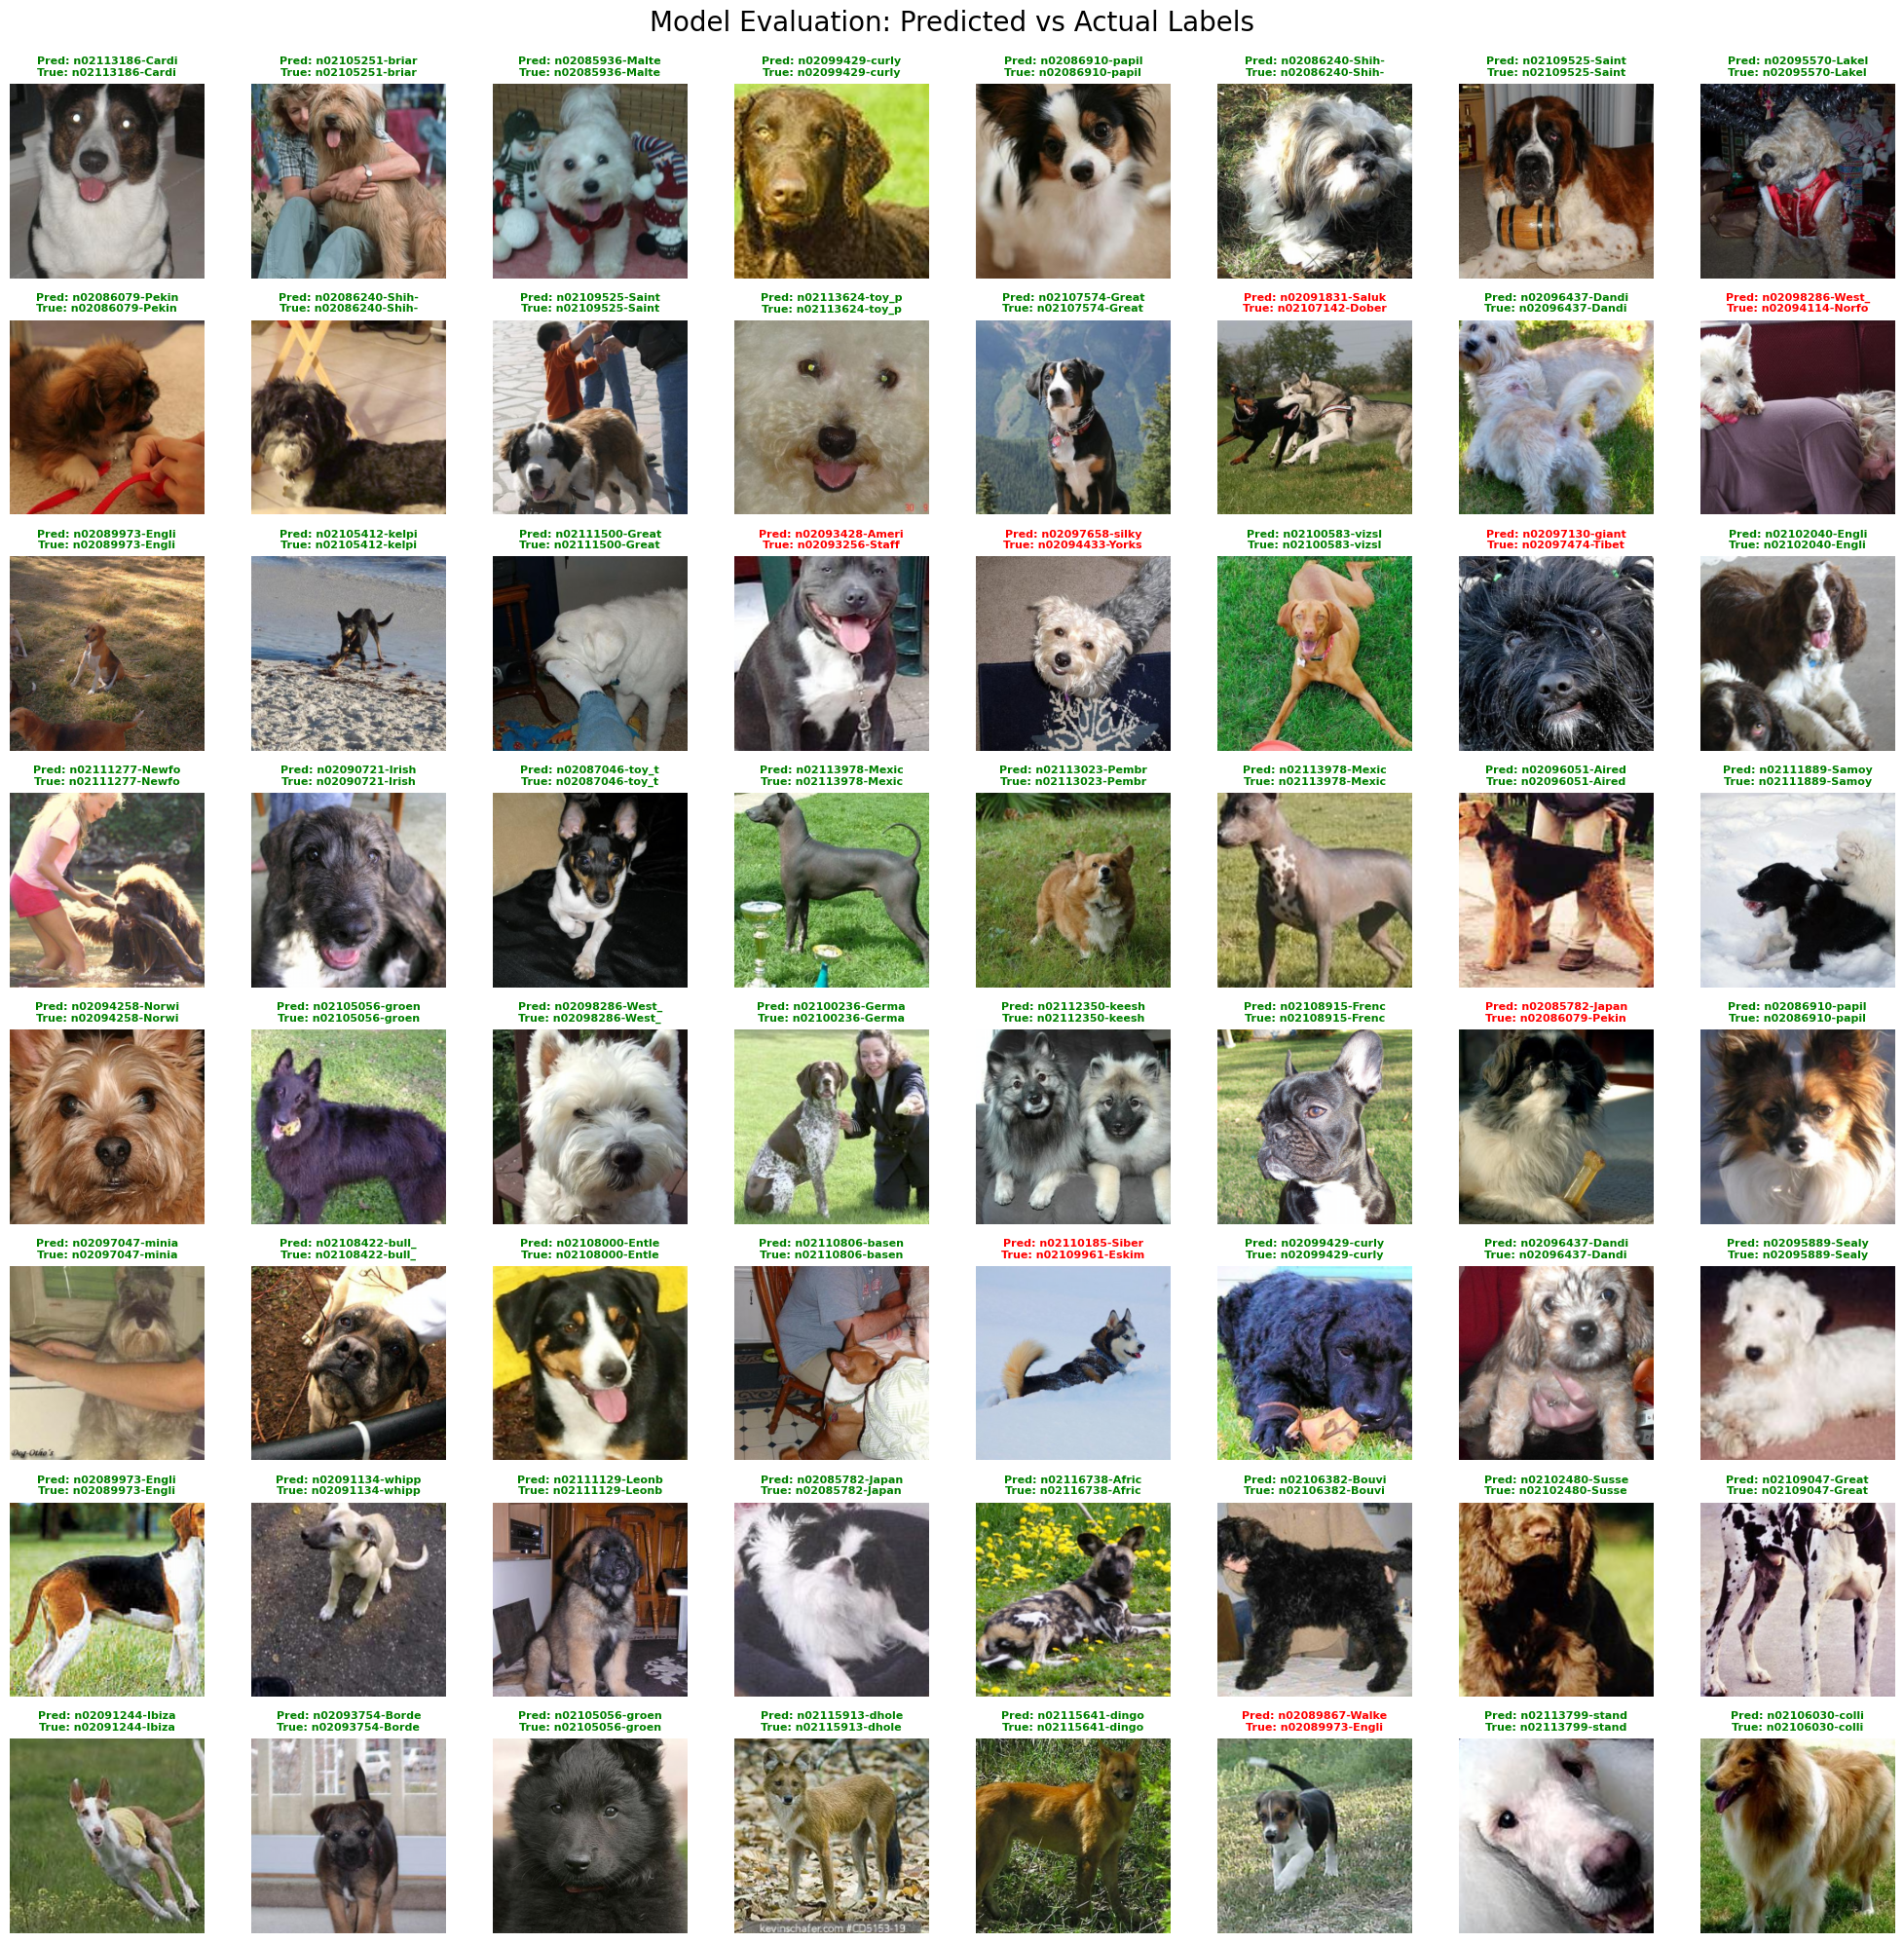


Accuracy trên 64 ảnh: 87.50%
Số ảnh dự đoán đúng: 56/64


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def evaluate_model_grid(model, dataloader, class_names, device, num_images=64):
    """
    Hiển thị grid 8x8 ảnh với nhãn thật và nhãn dự đoán
    
    Args:
        model: Model đã train
        dataloader: DataLoader (val hoặc test)
        class_names: List tên các class
        device: Device (cuda/cpu)
        num_images: Số lượng ảnh hiển thị (mặc định 64 = 8x8)
    """
    model.eval()
    
    # Lấy ngẫu nhiên các ảnh từ dataloader
    all_images = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Lưu lại
            all_images.extend(inputs.cpu())
            all_labels.extend(labels.cpu())
            all_preds.extend(preds.cpu())
            
            # Dừng khi đủ ảnh
            if len(all_images) >= num_images:
                break
    
    # Chọn ngẫu nhiên num_images ảnh
    indices = random.sample(range(len(all_images)), min(num_images, len(all_images)))
    
    # Tạo figure 8x8
    rows, cols = 8, 8
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    fig.suptitle('Model Evaluation: Predicted vs Actual Labels', fontsize=20, y=0.995)
    
    for idx, ax in enumerate(axes.flat):
        if idx < len(indices):
            img_idx = indices[idx]
            img = all_images[img_idx]
            true_label = all_labels[img_idx].item()
            pred_label = all_preds[img_idx].item()
            
            # Denormalize ảnh
            img = img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            # Hiển thị ảnh
            ax.imshow(img)
            ax.axis('off')
            
            # Tạo title với màu sắc
            is_correct = (true_label == pred_label)
            color = 'green' if is_correct else 'red'
            
            # Title: Pred / True
            title = f"Pred: {class_names[pred_label][:15]}\nTrue: {class_names[true_label][:15]}"
            ax.set_title(title, fontsize=8, color=color, weight='bold')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Tính accuracy
    correct = sum([1 for i in indices if all_preds[i] == all_labels[i]])
    accuracy = correct / len(indices) * 100
    print(f"\n{'='*60}")
    print(f"Accuracy trên {len(indices)} ảnh: {accuracy:.2f}%")
    print(f"Số ảnh dự đoán đúng: {correct}/{len(indices)}")
    print(f"{'='*60}")

# Sử dụng hàm
# Đảm bảo đã import matplotlib
import matplotlib.pyplot as plt

# Gọi hàm với model đã train
evaluate_model_grid(
    model=model,  # Model của bạn
    dataloader=test_loader,  # Validation dataloader
    class_names=classes,  # List tên class
    device=device,  # Device
    num_images=64  # 8x8 = 64 ảnh
)